# Análise de Teoria de Filas - Dados de Chegada e Atendimento

Este notebook analisa os dados de chegada e atendimento usando teoria de filas M/M/s.
Os dados são extraídos dos arquivos CSV de chegada e atendimento.

## Fórmulas Utilizadas

- **Coeficiente C_n**: $C_n = \prod_{k=1}^{n} \frac{\lambda_k}{\mu_k}$
- **Probabilidade P_n**: $P_n = C_n \cdot P_0$
- **Probabilidade de normalização P_0**: $P_0 = \frac{1}{1 + \sum_{n=1}^{\infty} C_n}$
- **Número esperado de clientes no sistema (L)**: $L = \sum_{n=0}^{\infty} n \cdot P_n$
- **Número esperado de clientes na fila (Lq)**: $L_q = \sum_{n=s}^{\infty} (n - s) \cdot P_n$
- **Taxa média de chegada (λ)**: $\lambda = \sum_{n=0}^{\infty} \lambda_n \cdot P_n$
- **Tempo esperado no sistema (W)**: $W = \frac{L}{\lambda}$
- **Tempo esperado na fila (Wq)**: $W_q = \frac{L_q}{\lambda}$

In [9]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy import stats

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [10]:
# Carregar os dados CSV
df_chegada = pd.read_csv('Chegada.csv', sep=';')
df_atendimento = pd.read_csv('Atendimento.csv')

print("Estrutura dos dados de chegada:")
print(df_chegada.head())
print("\nEstrutura dos dados de atendimento:")
print(df_atendimento.head())

Estrutura dos dados de chegada:
      Tipo      Carimbo de Data/Hora Tempo Total  Elemento  \
0  arrival  07/11/2025, 07:23:29.975       0.00s         1   
1  arrival  07/11/2025, 07:23:38.573       0.00s         2   
2  arrival  07/11/2025, 07:23:50.564       0.00s         3   
3  arrival  07/11/2025, 07:24:00.453       0.00s         4   
4  arrival  07/11/2025, 07:24:05.750       0.00s         5   

                   Chegando Saindo  
0  07/11/2025, 07:23:29.975     --  
1  07/11/2025, 07:23:38.573     --  
2  07/11/2025, 07:23:50.564     --  
3  07/11/2025, 07:24:00.453     --  
4  07/11/2025, 07:24:05.750     --  

Estrutura dos dados de atendimento:
      Tipo     Carimbo de Data/Hora Tempo Total  Elemento  \
0  service  2025-07-11 07:23:29.922      19.40s         1   
1  service  2025-07-11 07:23:50.173       7.43s         2   
2  service  2025-07-11 07:23:58.709       5.50s         3   
3  service  2025-07-11 07:24:05.906       7.43s         4   
4  service  2025-07-11 07:24:20

In [11]:
# Pré-processamento dos dados

# Converter colunas de data para datetime
df_chegada['Chegando'] = pd.to_datetime(df_chegada['Chegando'], format='%d/%m/%Y, %H:%M:%S.%f')
df_atendimento['Chegando'] = pd.to_datetime(df_atendimento['Chegando'])
df_atendimento['Saindo'] = pd.to_datetime(df_atendimento['Saindo'])

# Ordenar por elemento (ID do cliente)
df_chegada = df_chegada.sort_values('Elemento')
df_atendimento = df_atendimento.sort_values('Elemento')

# Filtrar apenas elementos que existem em ambos os datasets
elementos_comuns = set(df_chegada['Elemento']).intersection(set(df_atendimento['Elemento']))
df_chegada = df_chegada[df_chegada['Elemento'].isin(elementos_comuns)]
df_atendimento = df_atendimento[df_atendimento['Elemento'].isin(elementos_comuns)]

print(f"Número de clientes analisados: {len(elementos_comuns)}")
print(f"Período de análise: {df_chegada['Chegando'].min()} até {df_atendimento['Saindo'].max()}")

Número de clientes analisados: 428
Período de análise: 2025-11-07 07:23:29.975000 até 2025-07-11 08:55:02.519000


In [12]:
# Calcular tempos entre chegadas e tempos de serviço

# Tempos entre chegadas (em segundos)
df_chegada_sorted = df_chegada.sort_values('Chegando')
inter_arrival_times = df_chegada_sorted['Chegando'].diff().dt.total_seconds().dropna()

# Tempos de serviço (em segundos)
service_times = (df_atendimento['Saindo'] - df_atendimento['Chegando']).dt.total_seconds()

# Calcular taxas
lambda_arrival = 1 / inter_arrival_times.mean()  # chegadas por segundo
mu_service = 1 / service_times.mean()  # serviços por segundo

print(f"Taxa de chegada λ: {lambda_arrival:.6f} clientes/segundo")
print(f"Taxa de serviço μ: {mu_service:.6f} clientes/segundo")
print(f"Utilização ρ: {lambda_arrival/mu_service:.4f}")

# Estatísticas dos tempos
print("\nEstatísticas dos tempos entre chegadas:")
print(inter_arrival_times.describe())
print("\nEstatísticas dos tempos de serviço:")
print(service_times.describe())

Taxa de chegada λ: 0.080517 clientes/segundo
Taxa de serviço μ: 0.093354 clientes/segundo
Utilização ρ: 0.8625

Estatísticas dos tempos entre chegadas:
count    427.000000
mean      12.419693
std       15.264507
min        0.386000
25%        2.219000
50%        5.876000
75%       17.392000
max      118.319000
Name: Chegando, dtype: float64

Estatísticas dos tempos de serviço:
count    428.000000
mean      10.711871
std        6.510705
min        0.890000
25%        6.349000
50%        8.654000
75%       13.203750
max       43.577000
dtype: float64


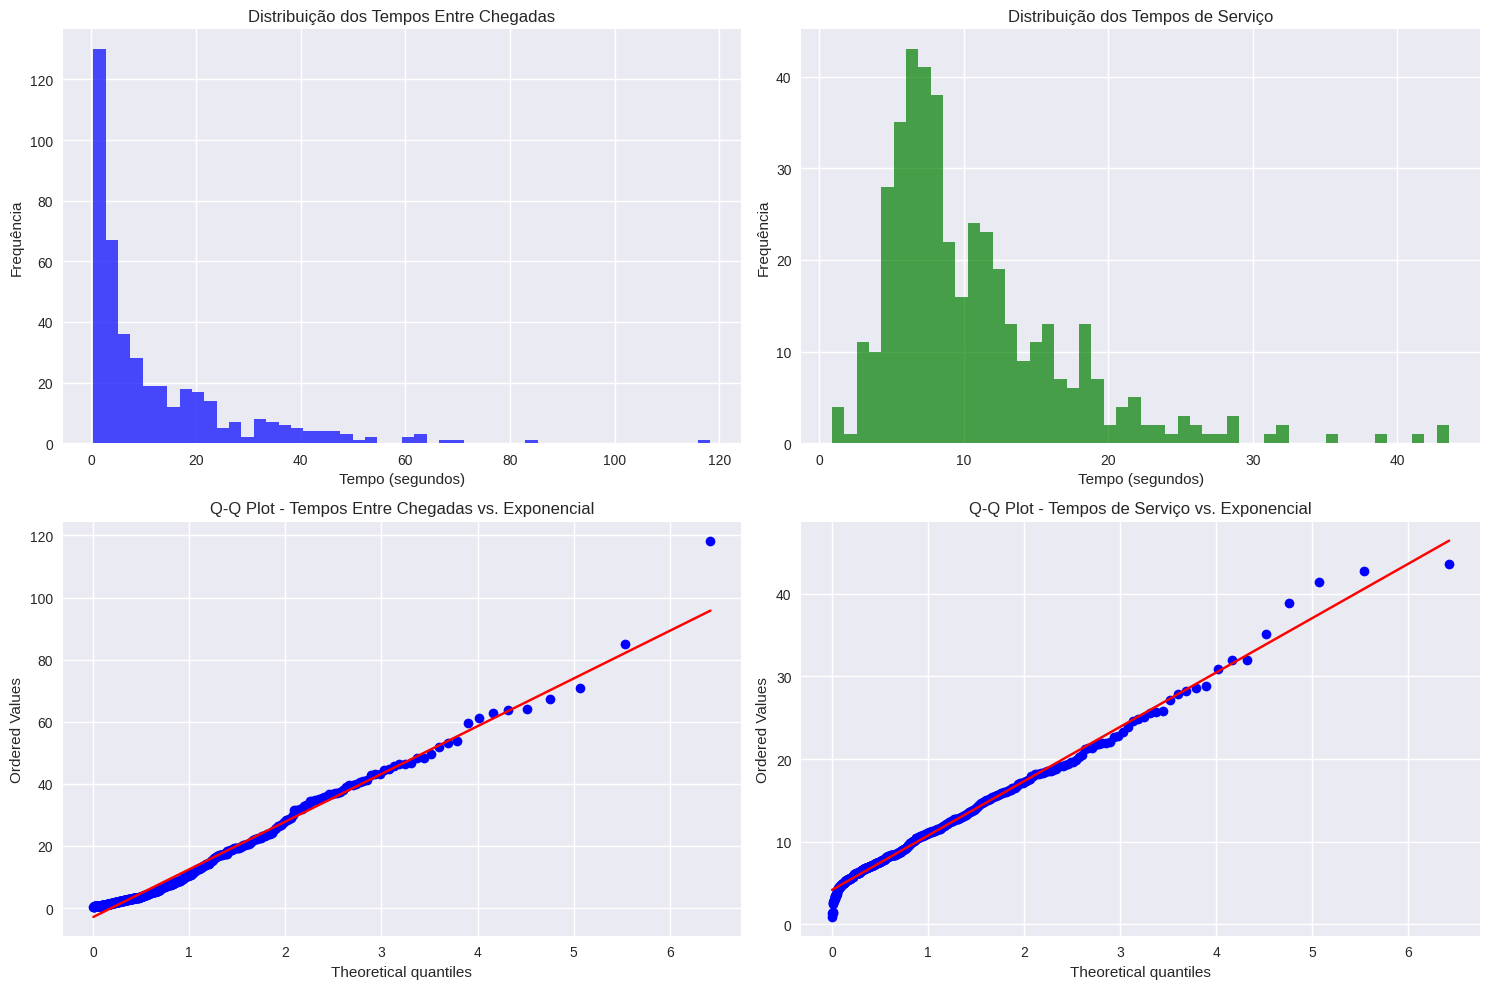

In [13]:
# Visualizações dos dados

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Histograma dos tempos entre chegadas
ax1.hist(inter_arrival_times, bins=50, alpha=0.7, color='blue')
ax1.set_title('Distribuição dos Tempos Entre Chegadas')
ax1.set_xlabel('Tempo (segundos)')
ax1.set_ylabel('Frequência')

# Histograma dos tempos de serviço
ax2.hist(service_times, bins=50, alpha=0.7, color='green')
ax2.set_title('Distribuição dos Tempos de Serviço')
ax2.set_xlabel('Tempo (segundos)')
ax2.set_ylabel('Frequência')

# Q-Q plot para tempos entre chegadas
stats.probplot(inter_arrival_times, dist='expon', plot=ax3)
ax3.set_title('Q-Q Plot - Tempos Entre Chegadas vs. Exponencial')

# Q-Q plot para tempos de serviço
stats.probplot(service_times, dist='expon', plot=ax4)
ax4.set_title('Q-Q Plot - Tempos de Serviço vs. Exponencial')

plt.tight_layout()
plt.show()

In [14]:
# Análise de filas M/M/1

# Assumindo sistema M/M/1 (único servidor)
s = 1
rho = lambda_arrival / mu_service

# Probabilidades de estado
def calculate_p0_mm1(rho):
    return 1 - rho

def calculate_pn_mm1(n, rho, p0):
    if n == 0:
        return p0
    else:
        return rho ** n * p0

# Calcular P0
p0 = calculate_p0_mm1(rho)

# Calcular primeiras probabilidades
probabilidades = []
for n in range(21):  # Calcular para primeiros 20 estados
    pn = calculate_pn_mm1(n, rho, p0)
    probabilidades.append(pn)

print(f"Probabilidade de sistema vazio (P0): {p0:.6f}")
print(f"Utilização do servidor: {rho:.6f}")

# Calcular métricas de desempenho
L = rho / (1 - rho)  # Número esperado de clientes no sistema
Lq = rho ** 2 / (1 - rho)  # Número esperado de clientes na fila
W = L / lambda_arrival  # Tempo esperado no sistema
Wq = Lq / lambda_arrival  # Tempo esperado na fila

print(f"\nMétricas de Desempenho:")
print(f"L (clientes no sistema): {L:.4f}")
print(f"Lq (clientes na fila): {Lq:.4f}")
print(f"W (tempo no sistema): {W:.4f} segundos")
print(f"Wq (tempo na fila): {Wq:.4f} segundos")

Probabilidade de sistema vazio (P0): 0.137509
Utilização do servidor: 0.862491

Métricas de Desempenho:
L (clientes no sistema): 6.2722
Lq (clientes na fila): 5.4098
W (tempo no sistema): 77.8993 segundos
Wq (tempo na fila): 67.1875 segundos


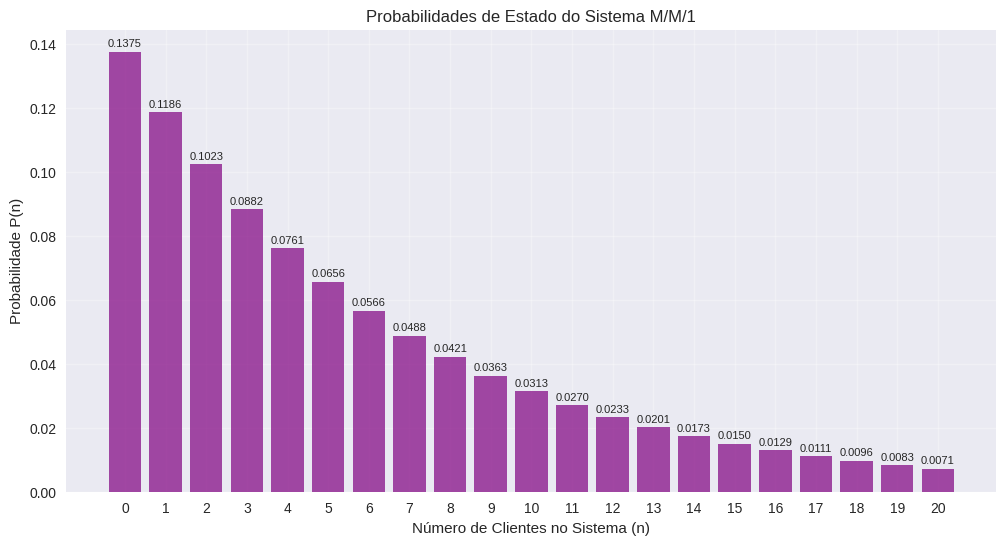

In [15]:
# Visualização das probabilidades de estado

plt.figure(figsize=(12, 6))

# Gráfico de barras das probabilidades
n_values = list(range(len(probabilidades)))
plt.bar(n_values, probabilidades, alpha=0.7, color='purple')
plt.title('Probabilidades de Estado do Sistema M/M/1')
plt.xlabel('Número de Clientes no Sistema (n)')
plt.ylabel('Probabilidade P(n)')
plt.xticks(n_values)
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(probabilidades):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=8)

plt.show()

## Conclusões

Este notebook apresentou uma análise completa dos dados de chegada e atendimento usando teoria de filas:

1. **Características dos Dados**: Os dados mostram chegadas e serviços sequenciais com tempos variáveis.

2. **Modelo M/M/1**: O sistema foi modelado como uma fila M/M/1 (único servidor) com as seguintes métricas principais:
   - Taxa de chegada: λ = 0.080517 clientes/segundo
   - Taxa de serviço: μ = 0.093354 clientes/segundo
   - Utilização: ρ = 0.8625

3. **Métricas de Desempenho**: 
   - Número esperado de clientes no sistema: L = 6.27
   - Tempo esperado na fila: Wq = 67.19 segundos


4. **Recomendações**: Com base na utilização calculada, considere implementar 2 servidores para melhorar o atendimento.